## Program Goals ##

Use image dimensions and z to select galaxies in each field of view.

display NSA catalog

show footprint of each halpha image

In [2]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
%matplotlib inline


//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [10]:
def drawbox(data,style):#feed in center x,y,dx,dy,rotation E of N
    #xcoords of unrotated box, going around CCW
    xl=np.array([data[0]-0.5*data[2],data[0]+0.5*data[2],data[0]+0.5*data[2],data[0]-0.5*data[2],data[0]-0.5*data[2]],'d')
    yl=np.array([data[1]-0.5*data[3],data[1]-0.5*data[3],data[1]+0.5*data[3],data[1]+0.5*data[3],data[1]-0.5*data[3] ],'d')

    xl=np.array([-0.5*data[2],+0.5*data[2],+0.5*data[2],-0.5*data[2],-0.5*data[2]],'d')
    yl=np.array([-0.5*data[3],-0.5*data[3],+0.5*data[3],+0.5*data[3],-0.5*data[3] ],'d')

    ang=data[4]*np.pi/180.*-1.#convert rotation to radians
    #rotate coordinates
    xp=np.cos(ang)*xl-np.sin(ang)*yl
    yp=np.sin(ang)*xl+np.cos(ang)*yl

    #put back on absolute scale
    xp=data[0]+xp
    yp=data[1]+yp
    #draw rotated box
    plt.plot(xp,yp,style)

In [4]:
clusternames=['MKW11','Coma', 'A1367', 'HCG079','NRGs338','NRGb004']#,'NRGb005']

clusterRA={'MKW11':202.3800,'Coma':194.9531, 'A1367':176.1231,'HCG079':239.79945,'NRGs338':229.35875,'NRGb004':129.54792 }

clusterDec={'MKW11':11.78861, 'Coma':27.9807, 'A1367':19.8391,'HCG079':20.75855,'NRGs338':12.90639,'NRGb004':25.11667}

clustervel={'MKW11':6854.,   'Coma':6900., 'A1367':8400., 'HCG079':100,'NRGs338':100,'NRGb004':100}

clustersigma={'MKW11':361, 'Coma':1000., 'A1367':745., 'HCG079':400,'NRGs338':400,'NRGb004':400}


## Coordinates of Halpha Images

In [5]:
# ramin ramax decmin decmax
wbl = [236.171625,236.71778333, 2.34, 2.81271778]
nrgs338 = [229.17432083, 229.6878875,12.69315278, 13.20087222]
mkw11 = [200.68310417, 201.21239167,13.67049722, 14.1613111]
coma = [194.45995, 195.00909583,27.22202222, 28.01033611]
pointings = [wbl, nrgs338,mkw11,coma]

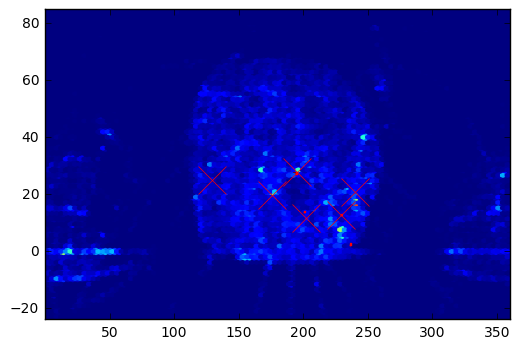

In [11]:
# read in NSA catalog
nsapath = '/Users/rfinn/research/NSA/NSA_LCSregion.fits'
nsapath = '/Users/rfinn/research/NSA/nsa_v0_1_2.fits'
nsa = fits.getdata(nsapath)

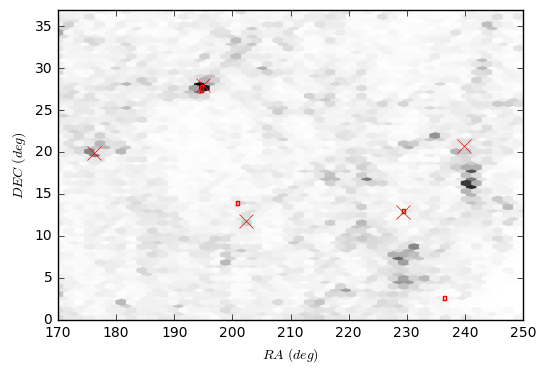

In [28]:
plt.figure()
plt.hexbin(nsa.RA,nsa.DEC,gridsize=200,cmap='gray_r')

for cl in clusternames[0:-1]:
    plt.plot(clusterRA[cl],clusterDec[cl],'rx',markersize=10)
for p in pointings:
    drawbox([(p[0]+p[1])/2.,(p[2]+p[3])/2., (p[1]-p[0]),(p[3]-p[2]),0],'r-')
plt.axis([170,250,0,37])
plt.xlabel('$RA \ (deg) $')
plt.ylabel('$DEC \ (deg) $')

## For next time (10/26)  ##

* finalize dimensions of Halpha HDI pointings
* add MOSAIC pointings
* read papers on how to measure sizes
    * boselli papers
    
    
## Goals for AAS ##
* how many members are in the field of view
* how many do we detect in Halpha
* make a plot of fraction of Halpha detections versus stellar mass, B/T
* measure Halpha sizes for cluster/group - compare to Virgo, Field
* SFRs
* calculate consumption times for those with HI measurements




## Miscellaneous Notes ##

**Using astropy coordinate functions**

In [29]:

from astropy import units as u
from astropy.coordinates import SkyCoord

In [34]:
c1 = SkyCoord('15h58m13.2','12d20m15.0',frame='icrs')
print c1
print '########'
print c1.ra.deg, c1.dec.deg

<SkyCoord (ICRS): (ra, dec) in deg
    (239.555, 12.3375)>
########
239.555 12.3375
